Because Bryan thought it might be worth trying.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
import h5py
%matplotlib inline

import nengo
import nengolib
from nengo.utils.matplotlib import rasterplot
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, BasicVecFeed, meg_from_spikes, list_as_ascii, gen_added_strings
from nengo_learn_assoc_mem.paths import proj_path

from collections import namedtuple
import os

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Full Vocab

## Setup

In [4]:
n_items = 16
dimensions = 32
n_neurons = 500
dt = 0.001
seed = 8

vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions,
                                                                                                                   seed+1, norm=True)

In [13]:
n_repeats = 1
t_pause = 0.1
t_present = 0.3
t_each = t_pause + t_present

td_each = int(t_each / dt)
td_pause = int(t_pause / dt)

intercepts = np.full(n_neurons, 0.2)

In [6]:
Stim = namedtuple("Stim", ['fan_num', 'targ', 'vecs'])

In [7]:
stim_vecs = {"fan1": Stim(1, True, np.array(fan1_pair_vecs)),
             "fan2": Stim(2, True, np.array(fan2_pair_vecs)),
             "foil1": Stim(1, False, np.array(foil1_pair_vecs)),
             "foil2": Stim(2, False, np.array(foil2_pair_vecs))}

In [9]:
with nengolib.Network(seed=seed) as model:
    pre_ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

with nengo.Simulator(model) as sim:
    pass

enc = sim.data[ens].encoders.copy()
pre_enc = sim.data[pre_ens].encoders.copy()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

# Train

In [28]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs
t_sim = n_repeats*len(feed_vecs)*t_each + t_pause

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    paused = nengo.Node(lambda t: feed.paused)
    
    pre_ens = nengo.Ensemble(n_neurons, dimensions,
                             encoders=pre_enc.copy(),
                             intercepts=intercepts, seed=seed)
    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=enc.copy(),
                         intercepts=intercepts, seed=seed)
    nengo.Connection(in_nd, pre_ens, synapse=None)
    conn = nengo.Connection(pre_ens, ens, solver=nengo.solvers.LstsqL2(weights=True),
                     learning_rule_type=nengo.BCM(1e-5))

    nengo.Connection(paused, ens.neurons, transform=-10*np.ones((n_neurons, 1)),
                     synapse=None)

    p_in = nengo.Probe(in_nd)
    p_paused = nengo.Probe(paused)
    p_weights = nengo.Probe(conn, "weights", sample_every=0.05)

with nengo.Simulator(model) as sim:
    sim.run(t_sim)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [29]:
fin_w = sim.data[p_weights][-1].copy()
fin_w.shape

(500, 500)

## Verification

In [30]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

In [35]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed, label="input")
    paused = nengo.Node(lambda t: feed.paused)
    meg_nd = nengo.Node(lambda t, x: np.sum(x),
                        size_in=n_neurons, size_out=1, label="meg")

    pre_ens = nengo.Ensemble(n_neurons, dimensions,
                             encoders=pre_enc.copy(),
                             intercepts=intercepts, seed=seed)
    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=enc.copy(),
                         intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, pre_ens, synapse=None)
    nengo.Connection(pre_ens.neurons, ens.neurons, transform=fin_w)

    nengo.Connection(paused, ens.neurons, transform=-10*np.ones((n_neurons, 1)),
                     synapse=None)
    
    nengo.Connection(ens.neurons, meg_nd, synapse=None)

    p_meg = nengo.Probe(meg_nd, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [36]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [37]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

In [38]:
test_meg = test_sim.data[p_meg].squeeze()

In [39]:
fan1_resp = test_meg[fan1_slc].reshape((-1, td_each))
fan2_resp = test_meg[fan2_slc].reshape((-1, td_each))
foil1_resp = test_meg[foil1_slc].reshape((-1, td_each))
foil2_resp = test_meg[foil2_slc].reshape((-1, td_each))

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


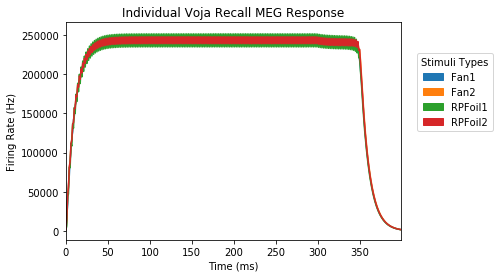

In [40]:
stim_types = ("Fan1", "Fan2", "RPFoil1", "RPFoil2")

sns.tsplot(fan1_resp, color="C0")
sns.tsplot(fan2_resp, color="C1")
sns.tsplot(foil1_resp, color="C2")
sns.tsplot(foil2_resp, color="C3")

plt.title("Individual Voja Recall MEG Response")
leg_handles = [mpatches.Patch(color=f"C{a_i}", label=nm) for a_i, nm in enumerate(stim_types)]
plt.legend(handles=leg_handles, title="Stimuli Types", loc=(1.05, 0.5))
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (ms)")
plt.savefig(os.path.join(proj_path, "plots", "bad_meg.pdf"), format="pdf", bbox_inches="tight")